In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
args = {
    "dataset": r"D:\deep learning\garbage detection", 
    "plot": "plot.png",
    "model": "mask_detectorch.model"
}

In [3]:
INIT_LR = 1e-4
EPOCHS = 15
BS = 8

In [4]:
print("[INFO] loading images from the dataset...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

[INFO] loading images from the dataset...


In [5]:
for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(label)

In [6]:
#data= np.array(data, dtype="float32")
#labels = np.array(labels)


In [7]:
import collections
count1=collections.Counter(labels)
print(count1)

Counter({'paper': 1050, 'cardboard': 891, 'plastic': 865, 'white-glass': 775, 'metal': 769, 'garbage detection': 1})


In [8]:
data1=[]
label1=[]
for i in range(len(labels)):
    if count1[labels[i]]>1:
        data1.append(data[i])
        label1.append(labels[i])
        
data = np.array(data1, dtype="float32")
labels = np.array(label1)


In [9]:
lb =LabelEncoder()
labels= lb.fit_transform(labels)

In [10]:
print(collections.Counter(labels))

Counter({2: 1050, 0: 891, 3: 865, 4: 775, 1: 769})


In [11]:
len(data)
len(labels)

4350

In [12]:

(trainX, testX, trainY, testY) = train_test_split(
	data, labels, test_size=0.3, stratify=labels, random_state=42
)


In [13]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

H, W, C = trainX.shape[1:]
ros = RandomOverSampler()
X_flat = trainX.reshape(len(trainX), -1)
X_resampled, y_resampled = ros.fit_resample(X_flat, trainY)

trainX = X_resampled.reshape(-1, H, W, C)
trainY = y_resampled
trainX, trainY = shuffle(trainX, trainY, random_state=42)

In [14]:
trainY.shape

(3675,)

In [15]:

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)
trainGen = aug.flow(trainX, trainY, batch_size=BS)

In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [17]:
baseModel.trainable = False
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

In [18]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
'''for layer in baseModel.layers[-30:]:
	layer.trainable = False'''

'for layer in baseModel.layers[-30:]:\n\tlayer.trainable = False'

In [20]:
baseModel.trainable = False

# Then unfreeze and fine-tune
baseModel.trainable = True
for layer in baseModel.layers:
    if "batch_normalization" in layer.name:
        layer.trainable = False

In [21]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [22]:
trainY.shape

(3675,)

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 0.9764309764309764, 1: 1.1313394018205463, 2: 0.8285714285714286, 3: 1.0057803468208093, 4: 1.1225806451612903}


In [24]:
print("Train shape:", trainX.shape)
print("Test shape:", testX.shape)
print("Train labels:", np.unique(trainY))
print("Test labels:", np.unique(testY))


Train shape: (3675, 224, 224, 3)
Test shape: (1305, 224, 224, 3)
Train labels: [0 1 2 3 4]
Test labels: [0 1 2 3 4]


In [25]:
'''smallX = trainX[:30]
smallY = trainY[:30]

model.fit(smallX, smallY, epochs=100, verbose=1)'''

'smallX = trainX[:30]\nsmallY = trainY[:30]\n\nmodel.fit(smallX, smallY, epochs=100, verbose=1)'

In [26]:
    print("[INFO] training head...")
    H = model.fit(
    trainGen,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    epochs=EPOCHS,
    class_weight=class_weights
)


[INFO] training head...
Epoch 1/15
459/459 [==============================] - 1452s 3s/step - loss: 0.9045 - accuracy: 0.6646 - val_loss: 0.5485 - val_accuracy: 0.8084
Epoch 2/15
459/459 [==============================] - 1316s 3s/step - loss: 0.5610 - accuracy: 0.8086 - val_loss: 0.4047 - val_accuracy: 0.8605
Epoch 3/15
459/459 [==============================] - 1291s 3s/step - loss: 0.4353 - accuracy: 0.8525 - val_loss: 0.5183 - val_accuracy: 0.8582
Epoch 4/15
459/459 [==============================] - 762s 2s/step - loss: 0.3614 - accuracy: 0.8765 - val_loss: 0.4200 - val_accuracy: 0.8820
Epoch 5/15
459/459 [==============================] - 363s 790ms/step - loss: 0.3075 - accuracy: 0.8966 - val_loss: 0.3081 - val_accuracy: 0.8973
Epoch 6/15
459/459 [==============================] - 367s 799ms/step - loss: 0.2752 - accuracy: 0.9092 - val_loss: 0.5078 - val_accuracy: 0.8567
Epoch 7/15
459/459 [==============================] - 364s 792ms/step - loss: 0.2669 - accuracy: 0.9078 - val

In [27]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
164/164 [==============================] - 28s 161ms/step


In [28]:
print(np.unique(testY))
print(np.unique(predIdxs))
print(np.unique(trainY))
print(predIdxs.shape)

[0 1 2 3 4]
[1.2766102e-17 1.8472252e-17 8.5968239e-17 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0 1 2 3 4]
(1305, 5)


In [29]:
target_names = ['cardboard', 'metal', 'paper', 'plastic', 'white-glass']
predIdxs = np.argmax(predIdxs, axis=1)
#testY=np.argmax(testY,axis=1)
print(classification_report(testY, predIdxs,
	target_names=target_names))


              precision    recall  f1-score   support

   cardboard       0.95      0.96      0.95       267
       metal       0.84      0.94      0.89       231
       paper       0.92      0.89      0.90       315
     plastic       0.83      0.87      0.85       260
 white-glass       0.93      0.79      0.86       232

    accuracy                           0.89      1305
   macro avg       0.89      0.89      0.89      1305
weighted avg       0.89      0.89      0.89      1305



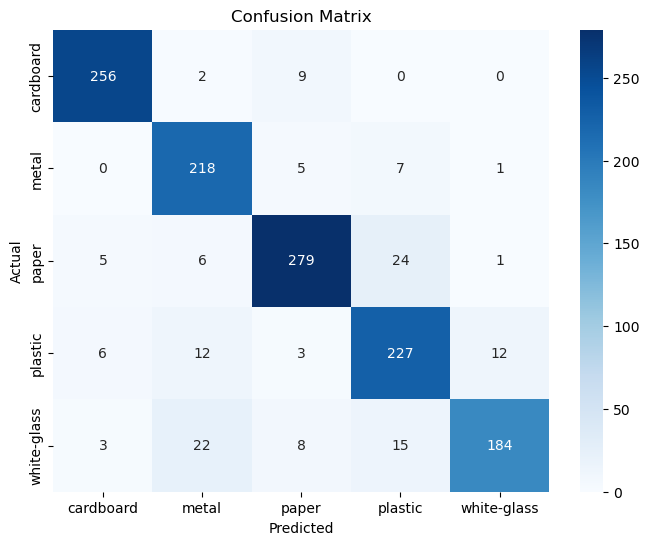

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(testY, predIdxs)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

[INFO] saving mask detector model...


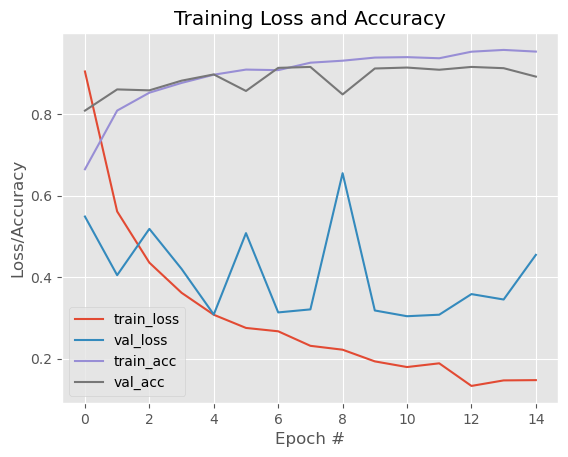

In [32]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])


In [33]:
model.save("garbage_classifier.h5")
